# Problem: Predicting residential utility costs based on attributes of the house. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns


## Data Wrangling

Let's read the file with actual data:

In [2]:
df = pd.read_csv('data/recs2015_public_v4.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5686 entries, 0 to 5685
Columns: 759 entries, DOEID to ZLPAMOUNT
dtypes: float64(262), int64(493), object(4)
memory usage: 32.9+ MB


It has 759 columns and 5686 rows. Let's take a look at the content:

In [4]:
df.head()

,DOEID,REGIONC,DIVISION,METROMICRO,UATYP10,TYPEHUQ,ZTYPEHUQ,CELLAR,ZCELLAR,BASEFIN,...,ZELAMOUNT,NGXBTU,PERIODNG,ZNGAMOUNT,FOXBTU,PERIODFO,ZFOAMOUNT,LPXBTU,PERIODLP,ZLPAMOUNT
0,10001,4,10,METRO,U,2,0,0,0,-2,...,0,103.32,1,0,137.45,-2,-2,91.33,-2,-2
1,10002,3,7,NONE,R,2,0,0,0,-2,...,1,NaN,-2,-2,137.45,-2,-2,91.33,-2,-2
2,10003,3,6,METRO,U,2,0,1,0,1,...,0,100.14,1,0,137.45,-2,-2,91.33,-2,-2
3,10004,2,4,MICRO,C,2,0,1,0,1,...,0,NaN,-2,-2,137.45,-2,-2,91.33,2,0
4,10005,1,2,METRO,U,2,0,1,0,0,...,0,102.83,1,0,137.45,-2,-2,91.33,-2,-2


It's hard to get meaning from columns names with the abbreviation, and categorical variables encrypted with codes, values of which are stored in a separate file. 
Let's read this file with description:

In [5]:
desc = pd.read_excel('data/codebook_publicv4.xlsx', skipfooter = 2)#, header=4, skiprows=3, )

In [6]:
desc.head()

,SAS Variable Name,Type,Length,Variable Description,Unnamed: 4,Final Response Set
0,DOEID,Character,5,Unique identifier for each respondent,10001 - \n15686,Unique identifier for each respondent
1,REGIONC,Numeric,8,Census Region,1\n2\n3\n4,Northeast\nMidwest\nSouth\nWest
2,DIVISION,Numeric,8,Census Division,1\n2\n3\n4\n5\n6\n7\n8\n9\n10,New England\nMiddle Atlantic\nEast North Centr...
3,METROMICRO,Character,5,Housing unit in Census Metropolitan Statistica...,1\n2\n3,Housing unit in Census Metropolitan Statistica...
4,UATYP10,Character,1,Census 2010 Urban Type,U\nC\nR,Urban Area\nUrban Cluster\nRural


In [7]:
desc.rename(columns={'Unnamed: 4': 'Code'}, inplace = True)

In [8]:
df.columns = desc['Variable Description'] #.apply(lambda x: x.lower().replace('number', 'n.'))

Initially, we renamed columns according to their description.
Now let's drop the columns which don't contain direct measures for our households:

In [9]:
df.drop(columns=[
        x for x in df.columns if 'Imputation' in x or 'conversion' in x or 'weight' in x], inplace=True)

In [10]:
df.shape

(5686, 441)

Now let's change categorical variables codes to their value:

In [11]:
for _, row in desc.iterrows():
    if ((type(row['Code']) == str) and not (" - " in row['Code'])):  # if categorocal
        codes = row['Code'].split('\n')
        if (codes[0].isdigit()):
            codes = [int(s) for s in codes]
        responses = row['Final Response Set'].split('\n')
        match = dict(zip(codes, responses))
        df.replace({row['Variable Description']: match}, inplace=True)
        if row['Variable Description'] in df.columns:
            df[row['Variable Description']
               ] = df[row['Variable Description']].astype('category')

Now that don't need supporting desc dataframe, let's rename columns of df and remove some duplicating ones:

In [12]:
df.rename(columns=lambda c: c.lower().replace('number', 'n.'), inplace=True)

In [13]:
df.head()

Variable Description,unique identifier for each respondent,census region,census division,housing unit in census metropolitan statistical area or micropolitan statistical area,census 2010 urban type,type of housing unit,housing unit over a basement,finished basement,attic above the housing unit,finished attic,...,"total usage for other devices and purposes not elsewhere classified, in thousand btu, 2015","total cost for other devices and purposes not elsewhere classified, in thousand btu, 2015",cords of wood used in the last year,"total cordwood usage, in thousand btu, 2015 (wood consumption is not included in totalbtu or totaldol)",n. of 40-pound wood pellet bags used in the last year,"total wood pellet usage, in thousand btu, 2015 (wood consumption is not included in totalbtu or totaldol)",n. of days covered by energy supplier survey electricity billing data and used to calculate annual consumption and expenditures,n. of days covered by energy supplier survey natural gas billing data and used to calculate annual consumption and expenditures,n. of days covered by energy supplier survey fuel oil/kerosene billing data and used to calculate annual consumption and expenditures,n. of days covered by energy supplier survey propane billing data and used to calculate annual consumption and expenditures
0,10001,West,Pacific,METRO,Urban Area,Single-family detached house,No,Not applicable,No,Not applicable,...,1749.457,94.09,-2.0,0.0,-2.0,0.0,330 days or more,330 days or more,"Not applicable, no fuel oil consumption","Not applicable, no propane consumption"
1,10002,South,West South Central,NONE,Rural,Single-family detached house,No,Not applicable,No,Not applicable,...,3188.852,104.88,-2.0,0.0,-2.0,0.0,No billing data collected or billing data not ...,"Not applicable, no natural gas consumption","Not applicable, no fuel oil consumption","Not applicable, no propane consumption"
2,10003,South,East South Central,METRO,Urban Area,Single-family detached house,Yes,Yes,No,Not applicable,...,3553.130,128.64,-2.0,0.0,-2.0,0.0,330 days or more,330 days or more,"Not applicable, no fuel oil consumption","Not applicable, no propane consumption"
3,10004,Midwest,West North Central,MICRO,Urban Cluster,Single-family detached house,Yes,Yes,No,Not applicable,...,1905.175,74.42,-2.0,0.0,-2.0,0.0,330 days or more,"Not applicable, no natural gas consumption","Not applicable, no fuel oil consumption",Less than 365 days (incomplete)
4,10005,Northeast,Middle Atlantic,METRO,Urban Area,Single-family detached house,Yes,No,Yes,No,...,3586.574,153.47,-2.0,0.0,-2.0,0.0,330 days or more,330 days or more,"Not applicable, no fuel oil consumption","Not applicable, no propane consumption"


In [14]:
df['building america climate zone'] = df['building america climate zone'].astype('category')

In [15]:
df.drop('census region', axis=1, inplace = True)
df.drop('housing unit in census metropolitan statistical area or micropolitan statistical area', axis=1)
df.drop('unique identifier for each respondent', axis=1, inplace = True)

### Missing values
Our data has no missing values, although t has a lot of 'Not applicable', like type of pool heating system for houses without a pool. Let's replace them with NaN.

In [16]:
sum(df.isnull().sum())

0

In [17]:
df.replace ('Not applicable', np.nan, inplace = True)
#df.replace ("Not applicable", np.nan, inplace = True)
df.replace (-2, np.nan, inplace = True) #-2 is code for Not applicable

Now let's form predictor variables. They are in columns prior to 'Total site electricity usage'. 

In [18]:
x_index = df.columns.get_loc('total site electricity usage, in kilowatthours, 2015')

In [19]:
X = df.iloc[:,1:x_index]

In [20]:
X.shape

(5686, 279)

Data has a lot of different consumption variables, but let's use the following:

In [21]:
Y_electicity = df['total site electricity usage, in kilowatthours, 2015']

In [22]:
Y_gas = df['total natural gas usage, in hundred cubic feet, 2015']

In [23]:
Y_propan = df['total propane usage, in gallons, 2015']

In [24]:
Y_oil = df['total fuel oil/kerosene usage, in gallons, 2015']

In [25]:
Y_electicity[Y_electicity>0].count()

5686

In [26]:
Y_gas[Y_gas>0].count()

3302

In [27]:
Y_propan[Y_propan>0].count()

573

In [28]:
Y_oil[Y_oil>0].count()

294

Columns with NaN values:

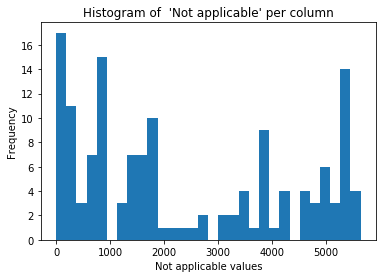

In [29]:
plt.hist(X.isnull().sum(axis=0), bins=30,
         range=(1, max(X.isnull().sum(axis=0))))
plt.title("Histogram of  'Not applicable' per column")
plt.xlabel('Not applicable values')
plt.ylabel('Frequency')
plt.show()

In [30]:
#X.to_csv('cleaned.csv')

We have a some columns with huge number of missing values. Some examples are as follows:

In [31]:
X.filter(like='pool')[65:75]

Variable Description,swimming pool,months swimming pool used in the last year,heated swimming pool,fuel used for heating swimming pool
65,No,NaN,NaN,NaN
66,Yes,3.0,Yes,Solar
67,No,NaN,NaN,NaN
68,No,NaN,NaN,NaN
69,No,NaN,NaN,NaN
70,No,NaN,NaN,NaN
71,NaN,NaN,NaN,NaN
72,No,NaN,NaN,NaN
73,Yes,5.0,Yes,Electricity
74,No,NaN,NaN,NaN


As we see with pool example, there could be no fuel used for a heating swimming pool if there is no pool, or it's heated, yet, we can't drop the entire column, because it's pools heated with solar energy would have a different impact than those running on electricity.
Same with grills:

In [32]:
X.filter(like='grill')[65:75]

Variable Description,outdoor grill used,fuels used by outdoor grill
65,No,NaN
66,Yes,Propane (bottled gas)
67,Yes,Propane (bottled gas)
68,Yes,Propane (bottled gas)
69,No,NaN
70,Yes,Charcoal
71,No,NaN
72,Yes,Propane (bottled gas)
73,Yes,Propane (bottled gas)
74,No,NaN


Some columns are linear dependent. Let's remove some of them. More would be found looking at correlation matrix.   

In [33]:
X.filter(like='rooms')[65:75]

Variable Description,n. of bedrooms,n. of full bathrooms,n. of half bathrooms,n. of other rooms,"total n. of rooms in the housing unit, excluding bathrooms"
65,4,1,1,2,6
66,3,2,0,5,8
67,3,1,2,4,7
68,3,2,0,2,5
69,2,1,1,3,5
70,3,1,1,2,5
71,1,1,0,2,3
72,4,2,1,5,9
73,4,3,0,8,12
74,3,1,0,3,6


In [34]:
X.drop('total n. of rooms in the housing unit, excluding bathrooms', axis=1, inplace = True)

In [35]:
X_numerical = X.select_dtypes(exclude=['category'])
cols = X_numerical.columns[X_numerical.isnull().any()].to_list()

In [36]:
for c in X.filter(like='summer temperature').columns:
    X[c].fillna(X[c].max(), inplace=True)

for c in X.filter(like='winter temperature').columns:
    X[c].fillna(X[c].min(), inplace=True)

In [37]:
X_numerical = X.select_dtypes(exclude=['category'])
cols = X_numerical.columns[X_numerical.isnull().any()].to_list()

In [38]:
for c in cols:
    X[c].fillna(0, inplace=True)

In [39]:
cols = X.columns[X.isnull().any()].to_list()
print(len(cols))

112


In [40]:
yes_no = set(X['energy star qualified freezer'].unique())

In [41]:
for c in cols:
    if (set(X[c].unique()).issubset(yes_no)): 
        X[c].fillna('No', inplace=True)

In [42]:
X['n. of light bulbs installed outside the home'].fillna('None', inplace=True)
X['n. of stories in a single-family home'].fillna('One story', inplace=True)
X['smart thermostat'].fillna('No', inplace=True)

In [43]:
X.drop(columns=[x for x in cols if 'second' in x], inplace=True)
X.drop(columns=['most-used tv usage on weekdays', 'most-used tv usage on weekends',
                'no space heating equipment, or unused space heating equipment',
                'who pays for fuel oil', 'who pays for natural gas', 'who pays for propane'
                ], inplace=True)

In [44]:
cols = X.columns[X.isnull().any()].to_list()
print(len(cols))
sorted(cols)

37


['age of central air conditioner',
 'age of clothes dryer',
 'age of clothes washer',
 'age of dishwasher',
 'age of main space heating equipment',
 'age of most-used freezer',
 'age of most-used individual air conditioning unit',
 'age of most-used refrigerator',
 'central air conditioner household behavior',
 'dishwasher cycle type',
 'display type of most-used tv',
 'door arrangement of most-used freezer',
 'door arrangement of most-used refrigerator',
 'fuel used by clothes dryer',
 'fuel used by cooktop part of stove',
 'fuel used by oven part of stove',
 'fuel used by separate cooktop',
 'fuel used by separate oven',
 'fuel used by stove',
 'fuel used for heating hot tub',
 'fuel used for heating swimming pool',
 'fuels used by outdoor grill',
 'main heating equipment household behavior',
 'main space heating equipment type',
 'main space heating fuel',
 'main water heater size',
 'major roofing material',
 'most-used individual air conditioning unit household behavior',
 'size o

In [45]:
X = X.fillna(X.mode().iloc[0]) #fill with the most frequent value

In [46]:
sum(X.isnull().sum())

0

### Outliers

In [47]:
X_numerical = X.select_dtypes(exclude=['category'])
X_numerical = X_numerical.loc[:, X_numerical.max().sort_values(ascending=False).index]

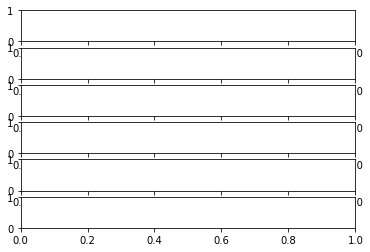

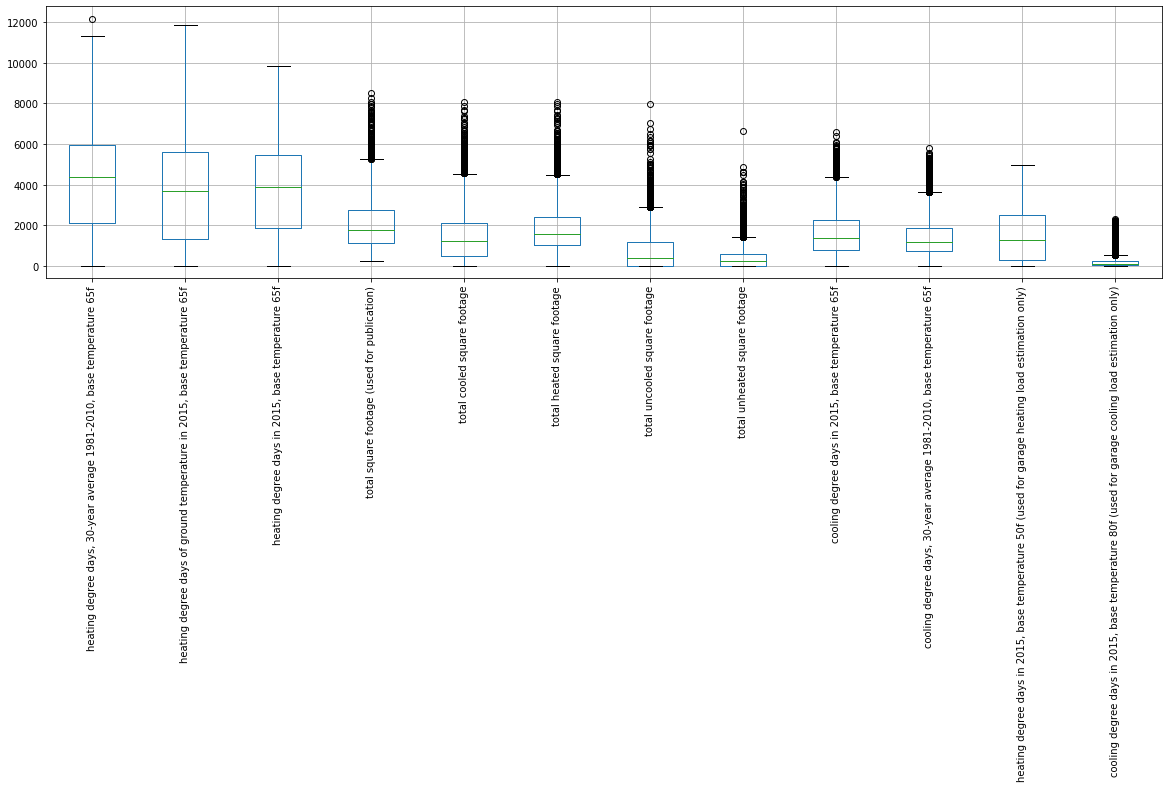

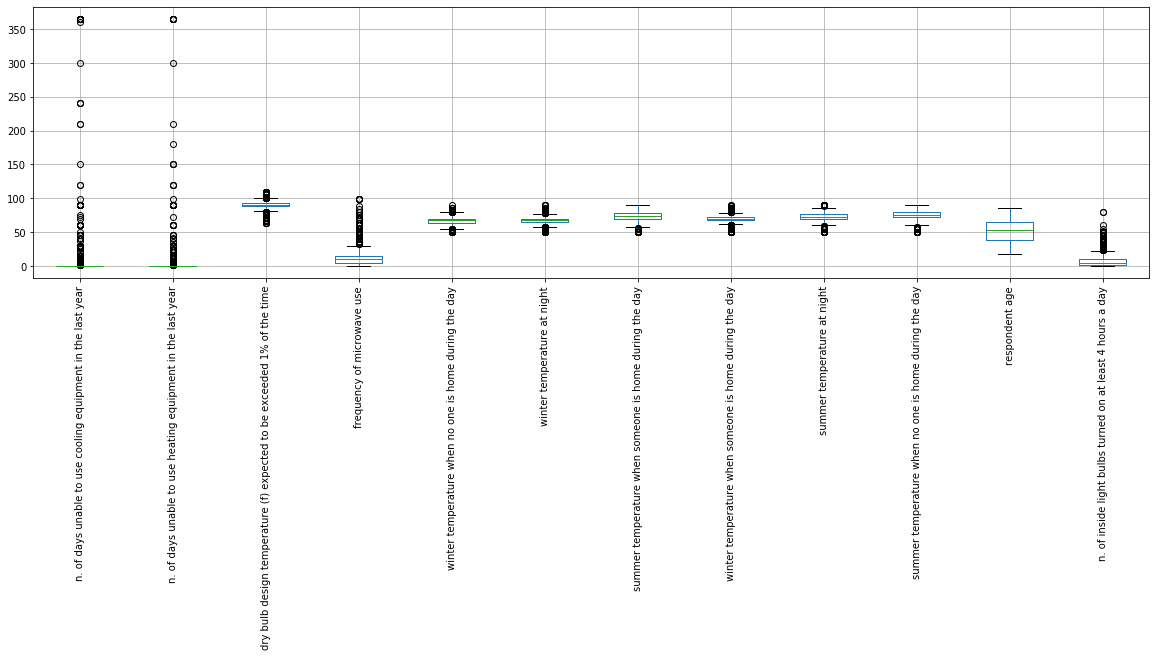

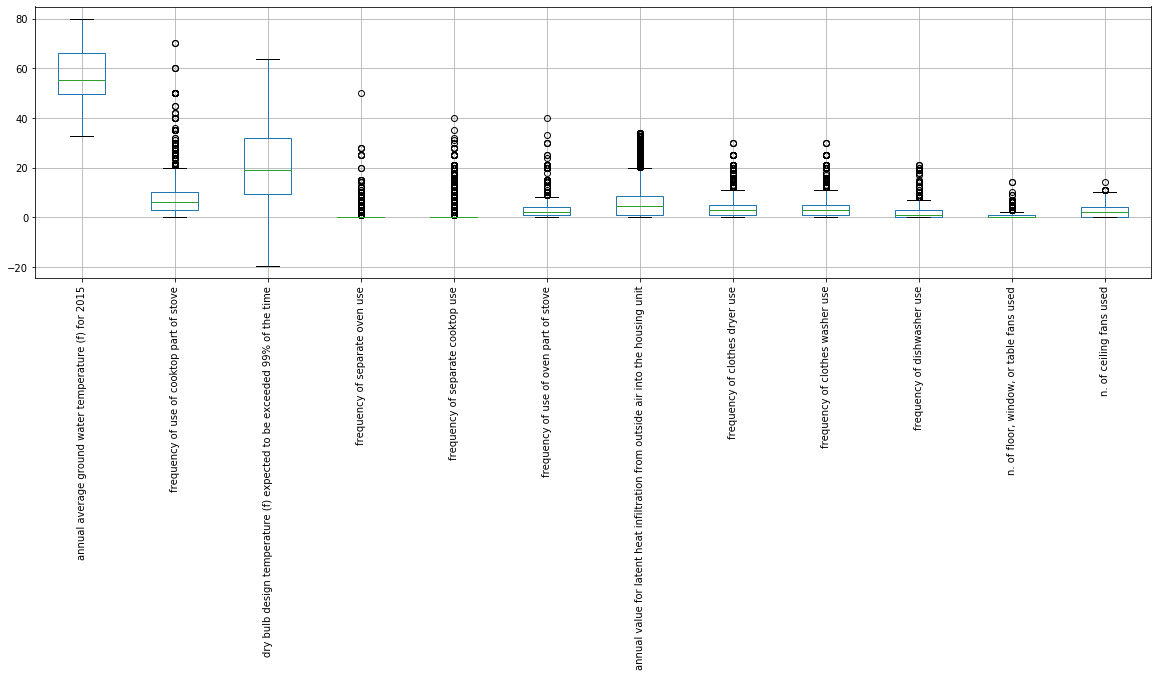

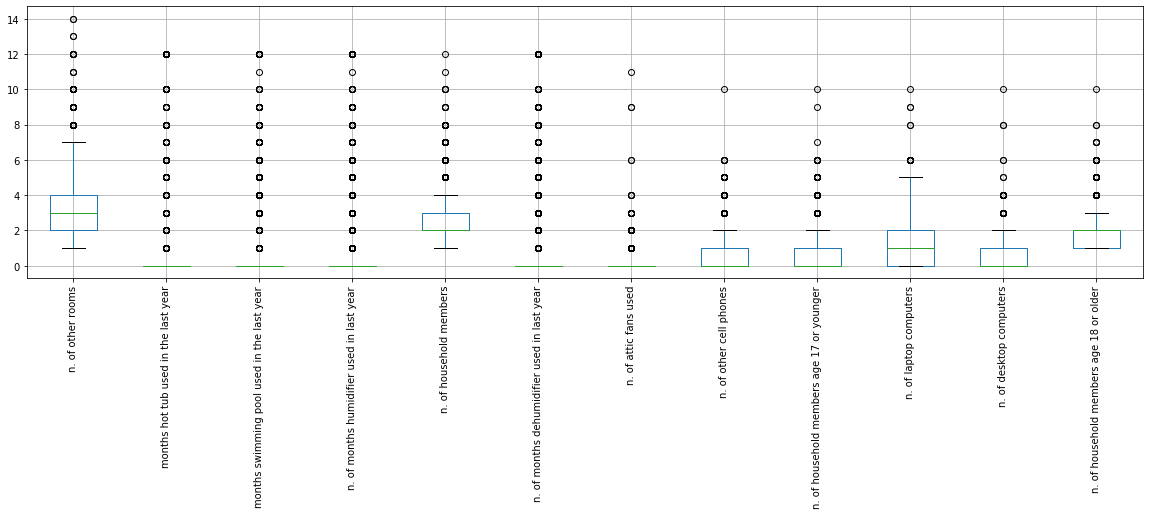

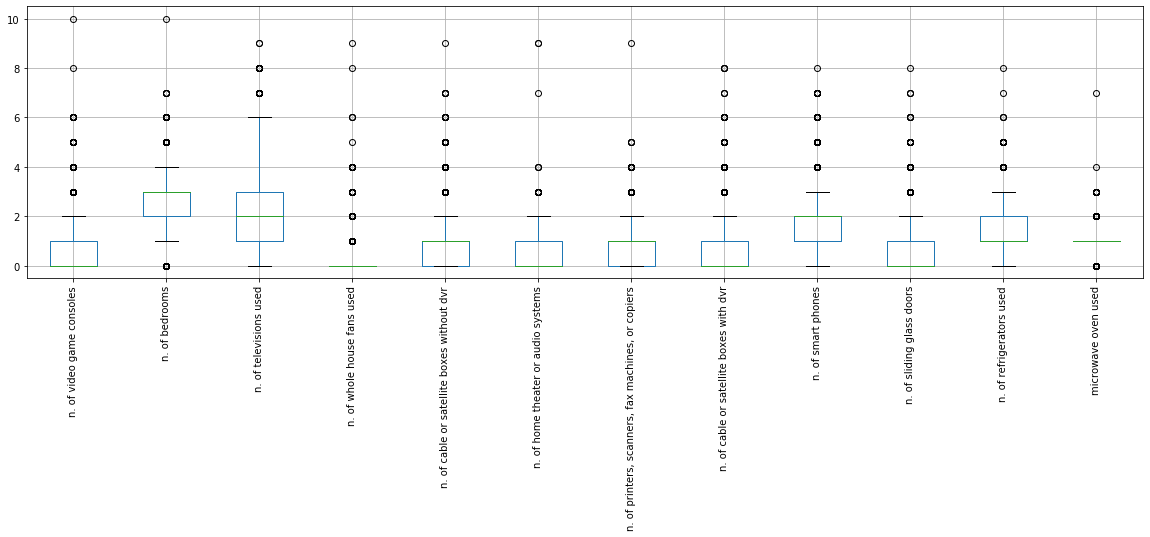

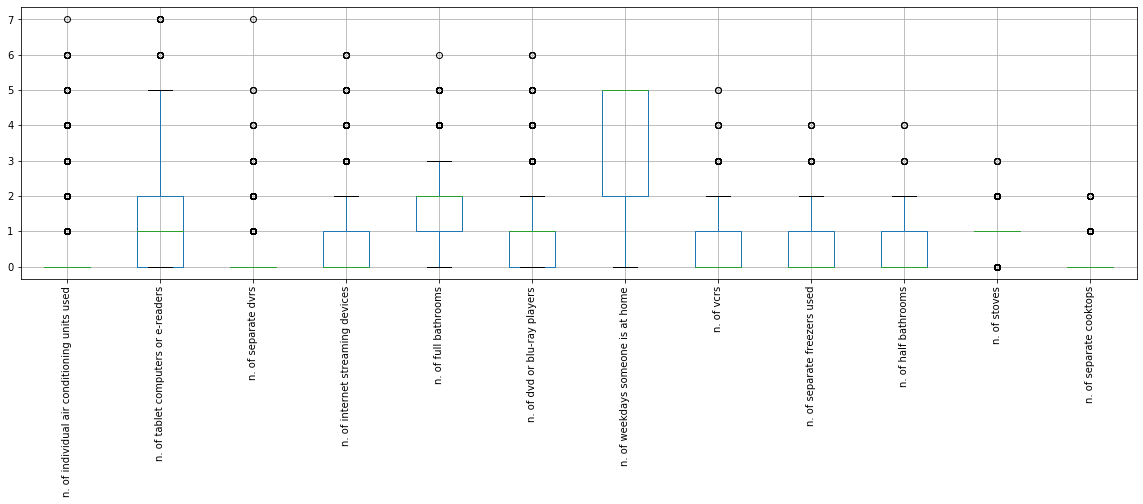

In [48]:
n = 12
fig, ax = plt.subplots(X_numerical.shape[1] // n, 1)
for i in range(0, X_numerical.shape[1] // n):
    plt.figure(figsize=(20, 5))
    ax[i] = X_numerical.iloc[:, i*n:i*n+n].boxplot(rot=90)

Base on boxplots, we can see that there are certain outliers, but non of them seems wrong - having 9 TVs is unusual, but still possible. 

### StandardScaler, OneHotEncoder

In [49]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [86]:
categorical_features = X.select_dtypes(include=['category']).columns
for c in categorical_features:
    X[c] = X[c].cat.remove_unused_categories()

In [66]:
numeric_features = X.select_dtypes(exclude=['category']).columns
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = X.select_dtypes(include=['category']).columns
categorical_transformer = Pipeline(
    steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [87]:
numeric_features = X.select_dtypes(exclude=['category']).columns
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features)])

In [88]:
X.loc[:,numeric_features]  = preprocessor.fit_transform(X)

In [91]:
X = pd.get_dummies(X, columns=categorical_features,
                   drop_first=True, dummy_na=False)

In [92]:
X

,n. of bedrooms,n. of full bathrooms,n. of half bathrooms,n. of other rooms,n. of sliding glass doors,months swimming pool used in the last year,months hot tub used in the last year,n. of refrigerators used,n. of separate freezers used,n. of stoves,...,iecc climate code_IECC climate zone 3A,iecc climate code_IECC climate zone 3C,iecc climate code_IECC climate zone 4A,iecc climate code_IECC climate zone 4C,iecc climate code_IECC climate zone 5A,iecc climate code_IECC climate zones 1A-2A,iecc climate code_IECC climate zones 3B-4B,iecc climate code_IECC climate zones 5B-5C,iecc climate code_IECC climate zones 6A-6B,iecc climate code_IECC climate zones 7A-7B-7AK-8AK
0,0.151021,0.339313,1.330824,0.395780,1.742252,-0.250706,-0.210964,-0.585652,1.077749,0.222444,...,0,0,0,0,0,0,1,0,0,0
1,-0.752881,-0.998645,-0.621463,-0.837995,-0.663977,-0.250706,-0.210964,-0.585652,1.077749,0.222444,...,0,0,0,0,0,1,0,0,0,0
2,1.054923,0.339313,-0.621463,1.012667,0.539137,-0.250706,-0.210964,0.895672,-0.652370,3.233909,...,1,0,0,0,0,0,0,0,0,0
3,0.151021,0.339313,-0.621463,0.395780,4.148481,-0.250706,-0.210964,0.895672,1.077749,0.222444,...,0,0,1,0,0,0,0,0,0,0
4,0.151021,0.339313,-0.621463,-0.221107,0.539137,-0.250706,-0.210964,0.895672,-0.652370,0.222444,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5681,-1.656783,-0.998645,-0.621463,-0.837995,-0.663977,-0.250706,-0.210964,-0.585652,-0.652370,0.222444,...,0,0,0,0,0,0,0,0,1,0
5682,0.151021,-0.998645,-0.621463,-0.837995,-0.663977,-0.250706,-0.210964,-0.585652,1.077749,0.222444,...,1,0,0,0,0,0,0,0,0,0
5683,-1.656783,-0.998645,-0.621463,-0.837995,-0.663977,-0.250706,-0.210964,-0.585652,1.077749,0.222444,...,0,0,0,0,1,0,0,0,0,0
5684,0.151021,0.339313,-0.621463,-0.837995,-0.663977,-0.250706,-0.210964,0.895672,-0.652370,0.222444,...,0,0,0,0,0,1,0,0,0,0


In [95]:
X.describe()

,n. of bedrooms,n. of full bathrooms,n. of half bathrooms,n. of other rooms,n. of sliding glass doors,months swimming pool used in the last year,months hot tub used in the last year,n. of refrigerators used,n. of separate freezers used,n. of stoves,...,iecc climate code_IECC climate zone 3A,iecc climate code_IECC climate zone 3C,iecc climate code_IECC climate zone 4A,iecc climate code_IECC climate zone 4C,iecc climate code_IECC climate zone 5A,iecc climate code_IECC climate zones 1A-2A,iecc climate code_IECC climate zones 3B-4B,iecc climate code_IECC climate zones 5B-5C,iecc climate code_IECC climate zones 6A-6B,iecc climate code_IECC climate zones 7A-7B-7AK-8AK
count,5.686000e+03,5.686000e+03,5.686000e+03,5.686000e+03,5.686000e+03,5.686000e+03,5.686000e+03,5.686000e+03,5.686000e+03,5.686000e+03,...,5686.000000,5686.000000,5686.000000,5686.000000,5686.000000,5686.000000,5686.000000,5686.000000,5686.000000,5686.000000
mean,5.572593e-16,-9.479657e-17,4.060925e-16,-2.138048e-16,-6.266922e-16,-7.248862e-16,-1.883044e-16,1.185982e-16,-1.805333e-16,-3.690330e-18,...,0.112030,0.036757,0.179564,0.037812,0.218079,0.148786,0.113261,0.058389,0.066127,0.010552
std,1.000088e+00,1.000088e+00,1.000088e+00,1.000088e+00,1.000088e+00,1.000088e+00,1.000088e+00,1.000088e+00,1.000088e+00,1.000088e+00,...,0.315431,0.188181,0.383858,0.190759,0.412978,0.355909,0.316939,0.234498,0.248526,0.102190
min,-2.560685e+00,-2.336603e+00,-6.214632e-01,-1.454882e+00,-6.639769e-01,-2.507059e-01,-2.109643e-01,-2.066975e+00,-6.523697e-01,-2.789021e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.528808e-01,-9.986450e-01,-6.214632e-01,-8.379947e-01,-6.639769e-01,-2.507059e-01,-2.109643e-01,-5.856515e-01,-6.523697e-01,2.224438e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.510213e-01,3.393134e-01,-6.214632e-01,-2.211074e-01,-6.639769e-01,-2.507059e-01,-2.109643e-01,-5.856515e-01,-6.523697e-01,2.224438e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.510213e-01,3.393134e-01,1.330824e+00,3.957800e-01,5.391374e-01,-2.507059e-01,-2.109643e-01,8.956717e-01,1.077749e+00,2.224438e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6.478336e+00,5.691147e+00,7.187685e+00,6.564654e+00,8.960938e+00,8.221886e+00,5.890992e+00,9.783611e+00,6.268104e+00,6.245374e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### ____________

In [ ]:
# Generate a custom diverging colormap

plt.figure(figsize=(20,20))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(X.corr(),  cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import r2_score

import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
sns.set(font_scale=1)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y_electicity, test_size=0.2)

In [ ]:
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    #'max_depth': 8, 
    'num_leaves': 20,
    "bagging_fraction" : 0.2,
    "feature_fraction" : 0.2,
    'learning_rate': 0.001,
    'verbose': 1, 
    "lambda_l2" : 2,
}

In [ ]:
trn_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_test, label=y_test)


evals_result = {}

lgb_clf = None
lgb_clf = lgb.train(lgb_params,
                        trn_data,
                        100000,
                        valid_sets = [trn_data, val_data],
                        early_stopping_rounds=3000,
                        verbose_eval = 2000,
                        evals_result=evals_result
                       )

In [ ]:
y_pred = lgb_clf.predict(X_test)

In [ ]:
r2_score(y_test, y_pred)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score
explained_variance_score(y_test, y_pred)

In [ ]:
mean_absolute_error(y_test, y_pred)

In [ ]:
lgb.plot_importance(lgb_clf, max_num_features = 30)
plt.show()

In [ ]:
plt.show()

In [ ]:
X_train

In [ ]:
y_test

In [ ]:
 y_pred